In [4]:
import pandas as pd
import seaborn as sns
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import nltk as nltk
#import pyarrow
import bz2
import json
import datetime
from iteration_utilities import deepflatten
import nltk as nltk
import scipy.stats as stats
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
pd.options.mode.chained_assignment = None

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\asbjo\AppData\Roaming\nltk_data...


In [5]:
#path_to_file = '/content/drive/MyDrive/Quotebank/'

files_pre_cleaning = ['quotes-2015.json-001.bz2','quotes-2016.json-002.bz2','quotes-2017.json.bz2',
                  'quotes-2018-004.json.bz2','quotes-2019-005.json.bz2','quotes-2020.json.bz2']

files_cleaned = ['clean-quotes-2015.csv.bz2','clean-quotes-2016.csv.bz2','clean-quotes-2017.csv.bz2',
                  'clean-quotes-2018.csv.bz2','clean-quotes-2019.csv.bz2','clean-quotes-2020.csv.bz2']

path_to_wikidata_file = '/content/drive/MyDrive/Project datasets/speaker_attributes.parquet'

wikidata_csv = '/content/drive/MyDrive/Project datasets/wikidata_labels_descriptions_quotebank.csv.bz2' 

In [6]:
def weekday_number(date):
  ''' Returning the weekday number of a date, e.g., 0 for Mondays.

  Parameters
  ----------
  date: datetime
    A datetime for which to find the weekday number.

  Returns
  -------
  weekday_number: int
    The weekday number of the date.
  '''

  weekday_number = date.weekday()
  return weekday_number


def weekday(date):
  ''' Returning the name of the weekday for a date.

  Parameters
  ----------
  date: datetime
    A datetime for which to find the weekday.

  Returns
  -------
  weekday: str
    The weekday of the date.
  '''
  
  day_number = date.weekday()
  week_days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
  weekday = week_days[day_number]
  return weekday


def week(date):
  ''' Returning the week number of a date.

  Parameters
  ----------
  date: datetime
    A datetime for which to find the weekday.

  Returns
  -------
  week_number: int
    The week number of the date.
  '''

  week_number = date.week()
  return week_number


def month(date):
  ''' Returning the month name of date.

  Parameters
  ----------
  date: datetime
    A date for which to find the month name.

  Returns
  -------
  name_month: str
    The name of the month.
  '''
  name_month = date.month_name()
  return name_month


def add_time(chunk):
  ''' Adding columns for weekday, weekday number and month name to a chunk.

  Parameters
  ----------
  chunk: dataframe
    The chunk for which to add date information.

  Returns
  -------
  chunk: dataframe
    The chunk with date information.
  '''

  chunk['weekday'] = chunk['date'].apply(lambda x: weekday(x))
  chunk['weekday_number'] = chunk['date'].apply(lambda x: weekday_number(x))  
  chunk['Month'] =  chunk['date'].apply(lambda x: month(x))
  chunk['date_short'] = pd.to_datetime(chunk['date']).dt.date
  return chunk


In [7]:
def add_dict(key, dictionary):
  ''' Incrementing the value of a key in a dictionary.
  
  Parameters
  ----------
  key: object
    The key for which to increment the value.
  
  dictionary: dict
    A dictionary in which we are incrementing the value of the key, or adding the key if not already present.

  Returns
  -------
  dictionary: dict
    The given dictionary after incrementing the value.
  '''
  
  if key in dictionary:
    dictionary[key] += 1
  else:
    dictionary[key] = 1
  return dictionary


def to_dict(dictionary, chunk_column):
  ''' Making a column of a dataframe into a dictionary, e.g., making a dictionary where weekdays are keys,
  and the values are the number of occurences of the key in the key.
  
  Parameters
  ----------
  dictionary: dict
    An initalized dictionary, either containing some preset keys or empty.
  
  chunk_column: series
    A series containing a column of a dataframe.

  Returns
  -------
  dictionary: dict
    A dictionary containing the desired values and keys as descripted.
  '''

  chunk_column.apply(lambda x: add_dict(x, dictionary))
  return dictionary

In [8]:
def find_media(url, medias_list):
  ''' Returning the media outlet where the quote is found, 
  but only if the outlet is present in medias_list.
  
  Parameters
  ----------
  url: array
    An entry in the column 'urls' of the Quotebank dataset, where the first value is the first source where the quote was found.
  
  medias_list: array
    An array containing some chosen media outlets, e.g., 'nytimes'.
  
  Returns
  -------
  media: str
    The first entry in url if its present in medias_list.
  '''

  for string in medias_list:
    url_string = str(url[0])
    if string in url_string:
      media = string
      return media


def get_media(chunk, medias_list):
  ''' Adding column with the media outlet where the quote is first found, 
  but only if the outlet is present in medias_list.
  
  Parameters
  ----------
  chunk: dataframe  
    A chunk of the Quotebank dataset.

  medias_list: array
    An array containing some chosen media outlets represented as strings, e.g., 'nytimes'.

  Returns
  -------
  chunk: dataframe
    The given chunk of the dataset, now containing a column 'media_outlet' 
    keeping the media where the quote was first found.
  '''

  chunk['media_outlet'] = chunk['urls'].apply(lambda x: find_media(x, medias_list))
  return chunk

In [9]:
def occurences_stats(chunk):
  ''' Returning the median and 75-th percentile of 'numOccurences' for the given chunk, as well as the chunk size.
  
  Parameters
  ----------
  chunk: dataframe
    The dataframe keeping a chunk of the dataset.
  
  Returns
  -------
  chunk_stats: array
    An array keeping the median, 75-th percentile.
  '''
  
  median = chunk.numOccurrences.describe()['50%']
  third_quartile = chunk.numOccurrences.describe()['75%']
  chunk_stats = [median, third_quartile]
  return chunk_stats


def stats_entire_dataset(occurence_stats_list):
  ''' Aggregating and printing statistics on numOccurences for the entire data set based upon the values in occurence_stats_list.
  
  Parameters
  ----------
  occurence_stats_list: array
    A 2D-array containing median and 75th percentile for each chunk of the dataset.   
  '''

  avg_median = 0
  avg_75th = 0
  for element in occurence_stats_list:
    avg_median += element[0]
    avg_75th += element[1]
  avg_median = avg_median/len(occurence_stats_list)
  avg_75th = avg_75th/len(occurence_stats_list)

  print(f'Average of median for each chunk for numOccurences: {round(avg_median, 2)}')
  print(f'Average 75th quantile for each chunk for  numOccurences: {round(avg_75th, 2)}')


def add_length(chunk):
  ''' Helper function adding the length of each quote in a new column.
  
  Parameters
  ----------
  chunk: dataframe
    A chunk of the dataset.
    
  Returns
  -------
  chunk: dataframe
    The given chunk now containing a 'len_quote' column.
  '''

  chunk['len_quote'] = chunk['quotation'].apply(lambda x: len(str(x)))
  return chunk

In [ ]:
# Initializing an array that will store the mean and variance of 'numOccurences' as well as the size of a chunk
occurence_stats_list = []

# Initializing dictionaries for dates, weekdays and months that will store values for all the chunks
date_dictionary = {}

# Dictionaries for weekdays and months are initialized with keys to keep them in the correct order for later plotting
weekday_dictionary = {'Monday': 0, 'Tuesday': 0, 'Wednesday': 0, 'Thursday': 0,
                      'Friday': 0, 'Saturday': 0, 'Sunday': 0}

month_dictionary = {'January': 0, 'February': 0,'March': 0,
                    'April': 0, 'May': 0, 'June': 0, 
                    'July': 0, 'August': 0, 'September': 0,
                    'October': 0, 'November': 0, 'December': 0}

# Iterating through all the cleaned data sets in chunks
for x in range(len(files_pre_cleaning)): 
  print('Working on %d. dataset'%(x+1))
  df_reader = pd.read_json(path_to_file + files_pre_cleaning[x], lines=True, compression='bz2', chunksize=50000)
  for chunk in df_reader:
    chunk = add_time(chunk)
    
    # Inserting values in the dictionaries
    date_dictionary = to_dict(date_dictionary, chunk['date_short'])
    weekday_dictionary = to_dict(weekday_dictionary, chunk['weekday'])
    month_dictionary = to_dict(month_dictionary, chunk['Month'])

    # Generating descriptive stats for the chunk and adding them to occurence_stats_list
    occurence_stats_list.append(occurences_stats(chunk))

# Creating empty array to store dictionary values
arr = []
for element in date_dictionary.values():
    arr.append(element)
arr = np.array(arr)

# Calculating mean, std, and median for date_dictionary
mean = np.mean(arr)
std = np.std(arr)
median = np.median(arr)

In [21]:
#Bruker ikke per nå
#from empath import Empath
#lexicon = Empath()


In [10]:
from textblob import TextBlob

In [13]:
media_outlets = ['nytimes', 'wsj', 'womansday', 'nbcnews', 'foxnews', 'aarp', 'usmagazine', 'espn', 'usatoday', 
'newstoday', 'sportingnews', 'theguardian', 'people', 'tmz', 'mtv', 'cnn', 'msn', 'reuters', 'timesrepublican', 
'nationalgeographic', 'latimes', 'washingtonpost', 'startribune', 'chicagotribune', 'usnews', 'theathletic', 
'si', 'rollingstone', 'vanityfair', 'intouchweekly', 'starmagazine', 'bbc', 'independent', 'thesun', 'thetimes',
'express', 'dailymail', 'mirror', 'economist', ]

'''
chunk = get_media(chunk, media_outlets)
for element in media_outlets:
    media_chunk = chunk.loc[chunk['media_outlet'] == element]
    #print("Number of quotes in %s: %d"%(element, media_chunk.shape[0]))

'''


'\nchunk = get_media(chunk, media_outlets)\nfor element in media_outlets:\n    media_chunk = chunk.loc[chunk[\'media_outlet\'] == element]\n    #print("Number of quotes in %s: %d"%(element, media_chunk.shape[0]))\n\n'

In [15]:
# Initializing a sentiment analyzer
sent_analyzer = SentimentIntensityAnalyzer()

# Reading the data in chunks
df_reader = pd.read_json('quotes-2020.json.bz2', lines=True, compression='bz2', chunksize=500000)
for chunk in df_reader:
  
  #Dropping unnecesary columns
  

  # Calculating compound sentiment scores for the chunk and append the values in a column
  chunk['compound'] = chunk['quotation'].apply(lambda x: sent_analyzer.polarity_scores(x)['compound'])
  #chunk['positive'] = chunk['quotation'].apply(lambda x: sent_analyzer.polarity_scores(x)['pos'])
  #chunk['negative'] = chunk['quotation'].apply(lambda x: sent_analyzer.polarity_scores(x)['neg'])
  #chunk['blob_polar'] = chunk['quotation'].apply(lambda x: TextBlob(x).sentiment.polarity)
  #chunk = add_time(chunk)


  chunk = get_media(chunk, media_outlets)

  
  #monday_quotes = chunk.loc[chunk['weekday_number'] == 0]
  #friday_quotes = chunk.loc[chunk['weekday_number'] == 4]
  chunk = chunk.drop(axis=1, columns = 'quoteID')
  chunk = chunk.drop(axis=1, columns = 'phase')
  chunk = chunk.drop(axis=1, columns = 'quotation')
  chunk = chunk.drop(axis=1, columns = 'speaker')
  chunk = chunk.drop(axis=1, columns = 'qids')
  chunk = chunk.drop(axis=1, columns = 'date')
  chunk = chunk.drop(axis=1, columns = 'numOccurrences')
  chunk = chunk.drop(axis=1, columns = 'urls')

  chunk.to_csv(path_or_buf='quotes-2020-vader_compound.csv.bz2', compression='bz2', mode = 'a')
  print('chunk OK')


  

chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK
chunk OK


In [ ]:
df_reader = pd.read_json('quotes-2020_vader_compound.json.bz2', lines=True, compression='bz2', chunksize=5000000)
for chunk in df_reader:

break

In [75]:
# Looking at the differences in the sentiment across media outlets
espn = chunk.loc[chunk['media_outlet']=='espn']

print("Sentiment scores for quotes in ESPN:")
print(espn['compound'].describe())

Sentiment scores for quotes in ESPN:
count    2786.000000
mean        0.257457
std         0.447614
min        -0.916900
25%         0.000000
50%         0.273200
75%         0.636900
max         0.989000
Name: compound, dtype: float64


In [53]:
# Looking at the differences in the sentiment across media outlets
nytimes = chunk.loc[chunk['media_outlet']=='nytimes']

print("Sentiment scores for quotes in New York Times:")
print(nytimes['compound'].describe())

Sentiment scores for quotes in New York Times:
count    3568.000000
mean        0.074247
std         0.404358
min        -0.958400
25%        -0.077200
50%         0.000000
75%         0.386750
max         0.981600
Name: compound, dtype: float64


In [67]:
usmagazine = chunk.loc[chunk['media_outlet']=='usmagazine']

print("Sentiment scores for quotes in USmagazine:")
print(usmagazine['compound'].describe())

Sentiment scores for quotes in USmagazine:
count    827.000000
mean       0.267237
std        0.456941
min       -0.951400
25%        0.000000
50%        0.286900
75%        0.659350
max        0.994400
Name: compound, dtype: float64


In [54]:
wsj = chunk.loc[chunk['media_outlet']=='wsj']

print("Sentiment scores for quotes in the Wall Street Journal:")
print(wsj['compound'].describe())

Sentiment scores for quotes in the Wall Street Journal:
count    378.000000
mean       0.161874
std        0.441007
min       -0.880500
25%        0.000000
50%        0.041350
75%        0.510600
max        0.978100
Name: compound, dtype: float64


In [55]:
womansday = chunk.loc[chunk['media_outlet']=='womansday']

print("Sentiment scores for quotes in the Womansday:")
print(womansday['compound'].describe())

Sentiment scores for quotes in the Womansday:
count    31.000000
mean      0.186561
std       0.518135
min      -0.743000
25%      -0.177000
50%       0.000000
75%       0.669700
max       0.962700
Name: compound, dtype: float64


In [56]:
fox = chunk.loc[chunk['media_outlet']=='foxnews']

print("Sentiment scores for quotes in FOX news:")
print(fox['compound'].describe())

Sentiment scores for quotes in FOX news:
count    3945.000000
mean        0.093046
std         0.474749
min        -0.971900
25%        -0.226300
50%         0.000000
75%         0.476700
max         0.992300
Name: compound, dtype: float64


In [57]:
t, p = stats.ttest_ind(nytimes['compound'], wsj['compound'], equal_var=False)
print("Two sided paired t-test with null hypothesis: The mean mood in NYtimes equals the mean mood in Wall Street Journal:")
print(f"t-value: {t}, p-value: {p}")

Two sided paired t-test with null hypothesis: The mean mood in NYtimes equals the mean mood in Wall Street Journal:
t-value: -3.701782122842041, p-value: 0.0002408394123224489


In [59]:
nytimes = chunk.loc[chunk['media_outlet']=='nytimes']
print("Sentiment scores for quotes in New York Times:")
print(nytimes['compound'].describe())


Sentiment scores for quotes in New York Times:
count    3568.000000
mean        0.074247
std         0.404358
min        -0.958400
25%        -0.077200
50%         0.000000
75%         0.386750
max         0.981600
Name: compound, dtype: float64


In [60]:
nytimes['blob_polar']

78        0.200000
128       0.193182
374       0.300000
562       0.450000
564      -0.533333
            ...   
499276    0.166667
499694    0.000000
499780    0.000000
499799    0.357143
499863    0.000000
Name: blob_polar, Length: 3568, dtype: float64

In [61]:
print(nytimes['blob_polar'].describe())

count    3568.000000
mean        0.078764
std         0.258061
min        -1.000000
25%         0.000000
50%         0.000000
75%         0.200000
max         1.000000
Name: blob_polar, dtype: float64


(array([  19.,   20.,  106.,  129.,  360., 2087.,  474.,  264.,   59.,
          50.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

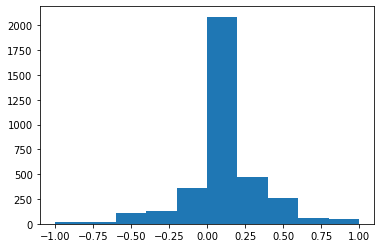

In [64]:
plt.hist(nytimes['blob_polar'])

(array([  86.,  170.,  271.,  270., 1340.,  222.,  324.,  441.,  316.,
         128.]),
 array([-0.9584, -0.7644, -0.5704, -0.3764, -0.1824,  0.0116,  0.2056,
         0.3996,  0.5936,  0.7876,  0.9816]),
 <a list of 10 Patch objects>)

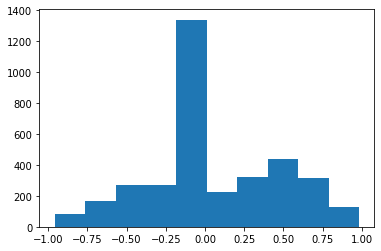

In [65]:
plt.hist(nytimes['compound'])

(array([ 20.,  21.,  42.,  30., 230.,  45.,  93., 105., 114., 127.]),
 array([-0.9514 , -0.75682, -0.56224, -0.36766, -0.17308,  0.0215 ,
         0.21608,  0.41066,  0.60524,  0.79982,  0.9944 ]),
 <a list of 10 Patch objects>)

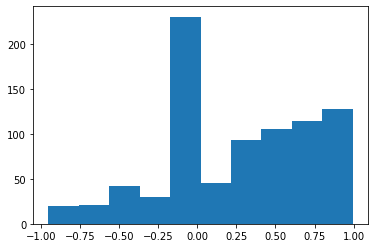

In [68]:
plt.hist(usmagazine['compound'])

In [80]:
nytimes

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,compound,positive,negative,blob_polar,blob_subj,weekday,weekday_number,Month,date_short,media_outlet
78,2020-04-10-002022,All the films and my life are thanks to my mot...,Bruce Baillie,[Q2926392],2020-04-10 23:47:23,1,"[[Bruce Baillie, 0.9506], [None, 0.0494]]",[http://nytimes.com/2020/04/10/movies/bruce-ba...,E,0.4404,0.146,0.000,0.200000,0.200000,Friday,4,April,2020-04-10,nytimes
128,2020-01-09-006199,Andrew Yang's Lies About Supporting Medicare f...,Andrew Yang,"[Q11118258, Q28723576]",2020-01-09 01:21:54,2,"[[Andrew Yang, 0.7197], [None, 0.2804]]",[https://www.nytimes.com/2020/01/08/opinion/me...,E,-0.0516,0.145,0.205,0.193182,0.375000,Thursday,3,January,2020-01-09,nytimes
374,2020-01-22-017789,eager to erase the image of congressional Repu...,Eric Cantor,[Q497271],2020-01-22 21:20:52,2,"[[Eric Cantor, 0.5013], [None, 0.3045], [Kevin...",[http://mobile.nytimes.com/2020/01/22/us/polit...,E,0.6249,0.254,0.000,0.300000,0.550000,Wednesday,2,January,2020-01-22,nytimes
562,2020-01-31-027972,How many players in the N.B.A. have a huge rol...,Brian Baldinger,[Q4963033],2020-01-31 10:00:17,4,"[[Brian Baldinger, 0.5348], [None, 0.3464], [D...",[http://www.nytimes.com/2020/01/31/sports/foot...,E,0.1655,0.130,0.000,0.450000,0.700000,Friday,4,January,2020-01-31,nytimes
564,2020-01-01-010404,How terrifying can this human be? How afraid o...,Simon Stone,[Q7519836],2020-01-01 15:00:09,2,"[[Simon Stone, 0.5783], [Rose Byrne, 0.3029], ...",[http://nytimes.com/2020/01/01/theater/simon-s...,E,-0.6199,0.000,0.253,-0.533333,0.666667,Wednesday,2,January,2020-01-01,nytimes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499276,2020-01-31-098461,This is an area where I frankly disagree with ...,Kevin Cramer,[Q3957020],2020-01-31 02:26:37,2,"[[Kevin Cramer, 0.6926], [None, 0.2458], [Mich...",[http://www.nytimes.com/2020/01/30/business/ec...,E,-0.6808,0.000,0.237,0.166667,0.333333,Friday,4,January,2020-01-31,nytimes
499694,2020-02-06-122735,We've heard a lot of candidates make a lot of ...,Michael Bloomberg,[Q607],2020-02-06 17:11:43,2,"[[Michael Bloomberg, 0.5358], [None, 0.4642]]",[http://mobile.nytimes.com/2020/02/06/us/polit...,E,0.1027,0.125,0.106,0.000000,0.000000,Thursday,3,February,2020-02-06,nytimes
499780,2020-03-17-089328,while they were still up and running.,None,[],2020-03-17 21:43:22,1,"[[None, 0.8751], [Branden Jacobs-Jenkins, 0.12...",[http://nytimes.com/2020/03/17/theater/theater...,E,0.0000,0.000,0.000,0.000000,0.000000,Tuesday,1,March,2020-03-17,nytimes
499799,2020-03-23-084212,"With large population centers, where people ar...",Steven Goodman,[Q2183197],2020-03-23 23:31:03,2,"[[Steven Goodman, 0.8217], [None, 0.1225], [Br...",[http://mobile.nytimes.com/2020/03/23/nyregion...,E,0.0000,0.000,0.000,0.357143,0.464286,Monday,0,March,2020-03-23,nytimes


In [82]:
date_dictionary = to_dict(date_dictionary, chunk['date_short'])

In [99]:
date = chunk.groupby('date_short').compound.mean()
day = chunk.groupby('weekday').compound.mean()
month = chunk.groupby('Month').compound.mean()

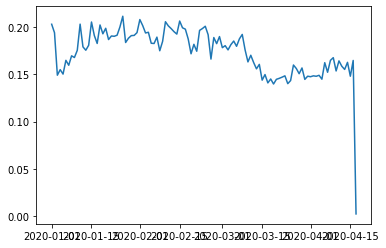

In [95]:
plt.plot(date)

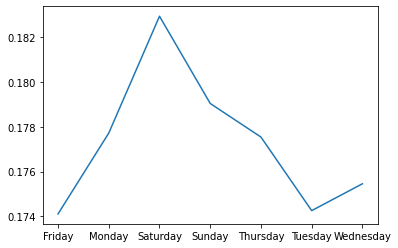

In [97]:
plt.plot(day)

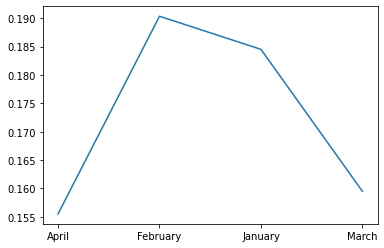

In [100]:
plt.plot(month)